In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, accuracy_score, f1_score, roc_curve, confusion_matrix, matthews_corrcoef, roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 16
sns.set_context('paper', font_scale=1.4)
pd.set_option('display.max_columns', None)

sns.set()
%matplotlib inline

#### 0. Przygotowanie Danych

In [8]:
test_df = pd.read_csv('data/UNSW_NB15_testing-set.csv', index_col=0)
train_df = pd.read_csv('data/UNSW_NB15_training-set.csv', index_col=0)

Podział danych na treningowe, testowe i walidacyjne

In [9]:
train_df, val_df = train_test_split(train_df, random_state=710, test_size=0.3)

In [10]:
X_train = train_df.drop(columns=['label', 'attack_cat'])
y_train = train_df['label']

X_val = val_df.drop(columns=['label', 'attack_cat'])
y_val = val_df['label']

X_test = test_df.drop(columns=['label', 'attack_cat'])
y_test = test_df['label']

In [11]:
numeric_columns = X_train.select_dtypes('number').columns
categorical_columns = X_train.select_dtypes('object').columns

#### 1. Feature Engineering

In [12]:
mi = mutual_info_classif(X_train[numeric_columns], y_train)
mi = pd.Series(data = mi, index = numeric_columns)

Poniżej mamy funkcję do usuwania zmiennych silnie skorelowanych w lepszy niż losowy sposób.

To znaczy staramy się wpierw usuwać te najmniej znaczące.

In [13]:
def remove_correlated_features(X, y = None, threshold = 0.65, features=numeric_columns, mi = None, corr_df = None):
    # at least one of 'y' and 'mi' must be not None
    assert(y is not None or mi is not None)
    if mi is None:
        mi = pd.Series(data = mutual_info_classif(X[features], y), index=features)
    if corr_df is None:
        corr_df = X.corr()

    # convert to an easier to use data frame
    corr_df = corr_df.melt(ignore_index=False).\
        reset_index(drop=False).\
        rename(columns={'index':'Var 1', 'variable': 'Var 2', 'value': 'Corr'})

    # we look for all pairs of (different) features that are highly correlated
    corr_df = corr_df[
                (np.abs(corr_df['Corr']) > threshold) & 
                (corr_df['Var 1'] != corr_df['Var 2'])
        ].\
        sort_values(by='Corr', ascending=False)

    removed_features = set()

    # ALGORYTM 2
    # usuwamy atrybuty od najmniej ważnych tak długo jak są pary silnie skorelowane

    mi = mi.sort_values()
    correlated_features = set(corr_df['Var 1']).union(set(corr_df['Var 2']))

    i = 0 
    while corr_df.shape[0] > 0 and i < mi.shape[0]:
        feature = mi.index[i]
        i += 1
        if feature not in correlated_features:
            continue
        correlated_features.remove(feature)
        removed_features.add(feature)
        corr_df = corr_df[(corr_df['Var 1'] != feature) & (corr_df['Var 2'] != feature)]

    return X.drop(list(removed_features), axis=1), list(removed_features)

In [14]:
X_train_reduced = remove_correlated_features(X_train, mi=mi)[0]
uncorrelated_columns = X_train_reduced.columns # to się przyda na potem

#### 2. Przygotowanie Pipelineów

Poniżej definiujemy kilka klas, które używamy przy budowaniu naszych Pipelineów.

In [15]:
class ColumnSelectorTransformer():
    def __init__(self, columns):
        self.columns = columns

    def transform(self, X, y=None):
        return X[self.columns]

    def fit(self, X, y=None):
        return self

In [16]:
numeric_transformer = Pipeline(
                        steps=[
                            ("scaler", StandardScaler())
                        ]
                      )

categorical_transformer = OneHotEncoder(drop='first')

def create_column_transformer(columns_to_use):
    numeric_columns_to_use = np.intersect1d(columns_to_use, numeric_columns)
    categorical_columns_to_use = np.intersect1d(columns_to_use, categorical_columns)
    
    return ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_columns_to_use),
            ("cat", categorical_transformer, categorical_columns_to_use),
        ]
    )

In [17]:
# columns_to_use = ['ct_dst_sport_ltm', 'sttl', 'dload', 'ct_state_ttl', 'dmean']
columns_to_use = np.intersect1d(uncorrelated_columns, mi.sort_values(ascending=False).index[:6])

#### 2.1 Przygotowanie Modelu XGBoost

In [18]:
preprocessor = Pipeline(
    steps=[
        ("column_selector", ColumnSelectorTransformer(columns=columns_to_use)),
        ("column_transformer", create_column_transformer(columns_to_use)),
    ]
)

xgb_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(random_state=710, eval_metric='logloss', use_label_encoder=False))
    ]
)

#### 3. Strojenie hiperparametrów

**3.1** Dostrajanie 1

In [19]:
xgb_parameters = {'classifier__n_estimators' : np.arange(10, 86, 25),
                'classifier__learning_rate' : np.logspace(-6, -1, 6),
                'classifier__subsample' : np.logspace(-1, 0, 5),
                'classifier__max_depth' : np.arange(5, 22, 4),
                'classifier__gamma' : np.logspace(-1, 3, 5),
                'classifier__min_child_weight' : np.logspace(0, 2, 5),
                # 'classifier__reg_lambda' : [2**x for x in range(-10,11)],
                # 'classifier__reg_alpha' : [2**x for x in range(-10,11)]
}

In [20]:
clf = RandomizedSearchCV(xgb_clf,
                         param_distributions=xgb_parameters,
                         cv=3,
                         n_jobs=-1,
                         n_iter=500,
                         scoring = 'roc_auc',
                         random_state=710,
                         verbose = 1
                        )

In [ ]:
clf.fit(X_train, y_train)

In [22]:
clf.best_params_

{'classifier__subsample': 1.0,
 'classifier__n_estimators': 60,
 'classifier__min_child_weight': 1.0,
 'classifier__max_depth': 13,
 'classifier__learning_rate': 0.1,
 'classifier__gamma': 1.0}

In [23]:
clf.best_score_

0.9856277412493658

In [24]:
tuning_results=pd.DataFrame(clf.cv_results_)
tuning_results.to_csv("tuning_results.csv")

In [25]:
tuning_results = pd.read_csv("tuning_results.csv")

**3.2** Dostrajanie 2

Większa przestrzeń parametrów. 3 Razy większy zbiór modeli do sprawdzenia.

In [34]:
xgb_parameters = {'classifier__n_estimators' : np.arange(20, 101, 10),
                'classifier__learning_rate' : np.logspace(-6, -1, 15),
                # 'classifier__subsample' : np.logspace(-1, 0, 5),
                'classifier__max_depth' : np.arange(10, 21),
                'classifier__gamma' : np.logspace(-1, 3, 6),
                'classifier__min_child_weight' : np.logspace(0, 2, 5),
                'classifier__reg_lambda' : np.arange(0,3),
                # 'classifier__reg_alpha' : [2**x for x in range(-10,11)]
}

In [35]:
clf2 = RandomizedSearchCV(xgb_clf,
                         param_distributions=xgb_parameters,
                         cv=3,
                         n_jobs=-1,
                         n_iter=1500,
                         scoring = 'roc_auc',
                         random_state=710,
                         verbose = 3
                        )

In [36]:
clf2.fit(X_train, y_train)

Fitting 3 folds for each of 1500 candidates, totalling 4500 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('column_selector',
                                                               <__main__.ColumnSelectorTransformer object at 0x000001BDB35539A0>),
                                                              ('column_transformer',
                                                               ColumnTransformer(transformers=[('num',
                                                                                                Pipeline(steps=[('scaler',
                                                                                                                 StandardScaler())]),
                                                                                                array(['ct_state_ttl', 'dbytes', 'rate', 'sbytes', 'sload', 'smean'],
      dtype=object))...
       7.19685673e-04, 1.63789371e-03, 3.72759372e-03, 8.48342898

In [37]:
clf2.best_params_

{'classifier__reg_lambda': 0,
 'classifier__n_estimators': 80,
 'classifier__min_child_weight': 1.0,
 'classifier__max_depth': 12,
 'classifier__learning_rate': 0.1,
 'classifier__gamma': 0.6309573444801934}

In [38]:
clf2.best_score_

0.9859032408271902

Niestety prawie 2h przeszukiwania dały pomijalnie mały wzrost metryki

#### 4. Ewaluacja Modelu

Sprawdzimy skuteczność znalezionego modelu.

In [46]:
# funkcja pomocnicza do ewaluacji modelu

def statistics_classification(y, y_pred, y_pred_proba):
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # plot roc curve
    fpr, tpr, _ = roc_curve(y,  y_pred_proba)
    axes[0].plot(fpr,tpr)
    axes[0].set_title('ROC curve')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_xlabel('False Positive Rate')
    # plt.show()

    # plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(ax = axes[1], data = cm, annot=True, fmt=".0f", 
        xticklabels=['0 (Not an attack)', '1 (Attack)'], yticklabels=['0 (Not an attack)', '1 (Attack)'])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Confusion matrix')
    plt.show()

    # display metrics
    auc = roc_auc_score(y, y_pred_proba)
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    matthews_coef = matthews_corrcoef(y, y_pred)

    print(f'{auc=}\n')
    print(f'{accuracy=}')
    print(f'{recall=}')
    print(f'{f1=}')
    print(f'{matthews_coef=}')

In [58]:
xgb_clf_tuned = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(random_state=710, eval_metric='logloss', use_label_encoder=False,
            reg_lambda = 0,
            n_estimators=80,
            min_child_weight=1.0,
            max_depth = 12,
            learning_rate = 0.1,
            gamma = 0.6309573444801934))
    ]
)

fitted


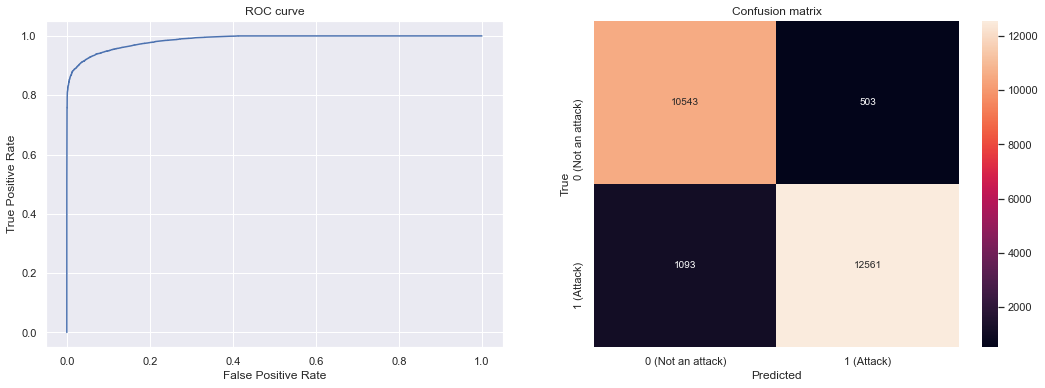

auc=0.9859961622065904

accuracy=0.9353846153846154
recall=0.9199501977442508
f1=0.9402649898944532
matthews_coef=0.8709822550207321


In [60]:
xgb_clf_tuned.fit(X_train, y_train)
print("fitted")
y_pred = xgb_clf_tuned.predict(X_val)
y_pred_proba = xgb_clf_tuned.predict_proba(X_val)[::, 1]

statistics_classification(y_val, y_pred, y_pred_proba)

#### Wnioski

Tuning parametrów nieco poprawił wcześniej uzyskiwane wyniki. Udało nam się osiągnąć metrykę AUC niemal równą jeden co było dla nas głównym celem.

Model cały czas ma miejsce na poprawki jednak biorąc pod uwagę bardzo długi czas uczenia modeli jesteśmy zadowoleni z osiągnięych rezultatów.